# Imports

In [1]:
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap

# Configs

In [36]:
INPUT_PATH = 'shoofer-demand-prediction/ML/datasets/'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

feature_list = ['prev_week_demand', 'prev_day_demand', 'month', 'day_month', 'day_week']

test_size_ratio = 0.25

AUTO_TUNE = False

# Data preparation


## Load Data

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [5]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [6]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [7]:
labeled_df = labeling(rides_df)

In [8]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


## Add Feature

In [9]:
def add_features(data):
    data['prev_day_demand'] = data.groupby(['Location'])['Demand'].shift(1)
    data['prev_week_demand'] = data.groupby(['Location'])['Demand'].shift(7)
    
    data = data.dropna()

    return data

In [10]:
features_df = add_features(labeled_df)

In [11]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (29606, 5)


,Location,Date,Demand,prev_day_demand,prev_week_demand
7,1,2023-01-08,12.0,6.0,40.0
8,1,2023-01-09,14.0,12.0,31.0
9,1,2023-01-10,4.0,14.0,27.0
10,1,2023-01-11,9.0,4.0,7.0
11,1,2023-01-12,8.0,9.0,15.0


## Extract Calendar features

In [12]:
def add_calendar_features(data):
    data['month'] = data['Date'].dt.month
    data['day_month'] = data['Date'].dt.day
    data['day_week'] = data['Date'].dt.dayofweek

    return data

In [13]:
date_features_df = add_calendar_features(features_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
print(f'date_features dataframe shape : {date_features_df.shape}')
date_features_df.head()

date_features dataframe shape : (29606, 8)


,Location,Date,Demand,prev_day_demand,prev_week_demand,month,day_month,day_week
7,1,2023-01-08,12.0,6.0,40.0,1,8,6
8,1,2023-01-09,14.0,12.0,31.0,1,9,0
9,1,2023-01-10,4.0,14.0,27.0,1,10,1
10,1,2023-01-11,9.0,4.0,7.0,1,11,2
11,1,2023-01-12,8.0,9.0,15.0,1,12,3


## Split Train and Test Data

In [15]:
def train_test_splitting(dataset, test_size):
    start_date = dataset['Date'].min()
    end_date = dataset['Date'].max()
    all_days = end_date - start_date

    train_df = dataset[(dataset['Date'] - start_date) < (1 - test_size) * all_days]
    test_df = dataset[(dataset['Date'] - start_date) >= (1 - test_size) * all_days]

    return train_df, test_df

In [16]:
train_df, test_df = train_test_splitting(date_features_df, test_size_ratio)

In [17]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (22008, 8)


,Location,Date,Demand,prev_day_demand,prev_week_demand,month,day_month,day_week
7,1,2023-01-08,12.0,6.0,40.0,1,8,6
8,1,2023-01-09,14.0,12.0,31.0,1,9,0
9,1,2023-01-10,4.0,14.0,27.0,1,10,1
10,1,2023-01-11,9.0,4.0,7.0,1,11,2
11,1,2023-01-12,8.0,9.0,15.0,1,12,3


In [18]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7598, 8)


,Location,Date,Demand,prev_day_demand,prev_week_demand,month,day_month,day_week
91,1,2023-04-02,17.0,13.0,14.0,4,2,6
92,1,2023-04-03,9.0,17.0,3.0,4,3,0
93,1,2023-04-04,12.0,9.0,14.0,4,4,1
94,1,2023-04-05,18.0,12.0,7.0,4,5,2
95,1,2023-04-06,10.0,18.0,13.0,4,6,3


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [19]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [51]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.1, 0.08, 0.06, 0.04, 0.02, 0.01], 
                'subsample':[0.8, 0.9, 1], 
                'colsample_bytree':[0.8, 0.9, 1], 
                'max_depth':range(2,10,1), 
                'gamma':[0, 1, 5]
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = feature_list, 
        cv = 5
        )
    
    print(best_params, best_score)
else:
    best_params = {'colsample_bytree': 0.8, 
                   'gamma': 0, 
                   'learning_rate': 0.08, 
                   'max_depth': 3, 
                   'subsample': 0.8, 
                   'n_estimators': 1000
                   }

### Prediction

In [52]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [53]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, feature_list)

### Visualization

In [40]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [41]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


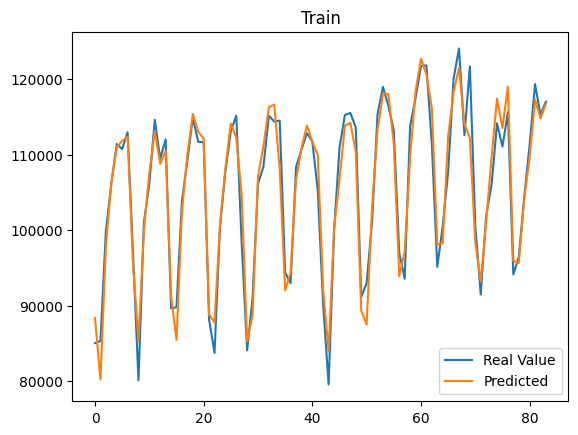

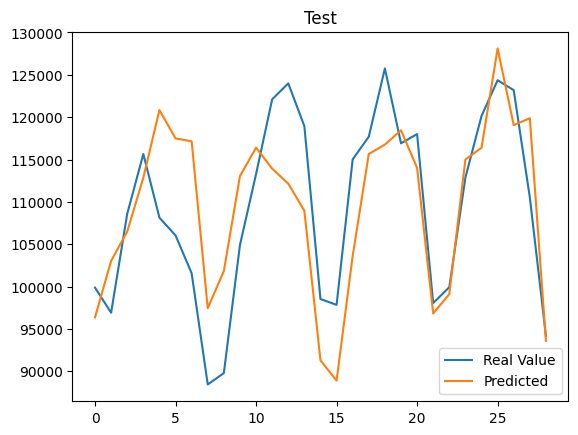

In [54]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [43]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [44]:
def evaluation(model_name, train_data, test_data, train_prediction_df , test_prediction_df ):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df )
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df )

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)


In [55]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)  # for whole data

XGB train scores:
MAE : 24.31470698550779
MSE : 4741.749504859299
XGB test scores:
MAE : 39.50635166123174
MSE : 14491.941127153874


### Feature Importance and SHAPE

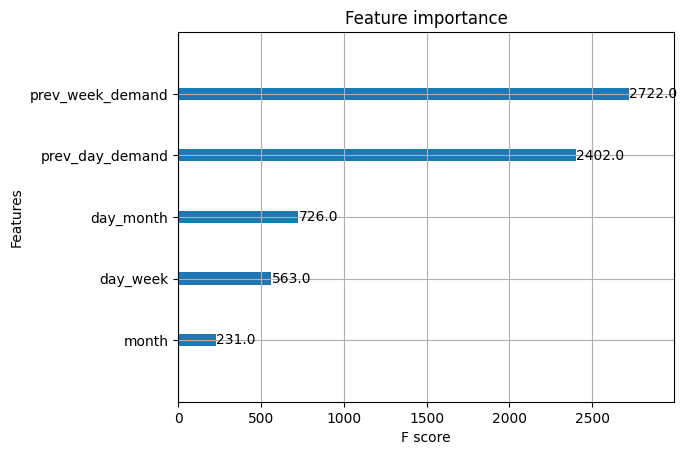

In [56]:
xgb.plot_importance(model)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


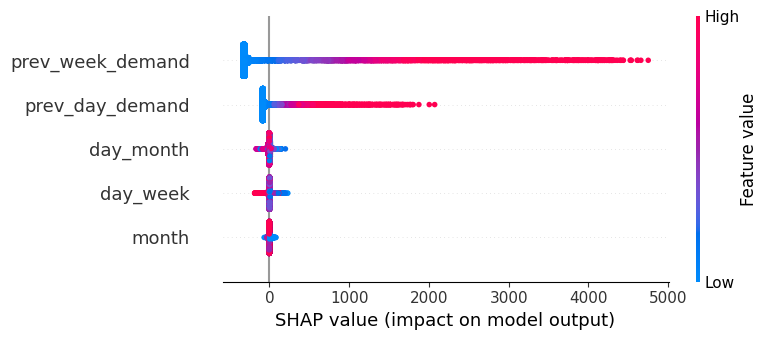

In [57]:
dtrain_reg = xgb.DMatrix(train_df[feature_list].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[feature_list])